In [1]:
from __future__ import division
import numpy as np
from numpy import exp
import t1t2shuffle as t1t2sh
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def numerical_gradient(myfun, myparams, e=1e-5):

    initial_params = myparams.copy()
    num_grad = np.zeros(initial_params.shape)
    perturb = np.zeros(initial_params.shape)
    
    for p in range(len(initial_params)):
        
        perturb[p] = e
        
        loss2 = myfun(myparams + perturb)
        loss1 = myfun(myparams - perturb)
        
        num_grad[p] = (loss2 - loss1) / (2 * e)
        
        perturb[p] = 0.

        return num_grad

In [3]:
def read_angles(fliptable):
    f = open(fliptable, 'r')
    angles = []
    for line in f.readlines():
        angles.append(float(line))
    f.close()
    return np.array(angles)

forward model time: 0.0245368480682
T2 derivative time: 0.00512886047363
T1 derivative time: 0.00502800941467
M0 derivative time: 0.00143814086914
B1 derivative time: 0.00449514389038
alpha derivative time: 0.022901058197

total grad time: 0.0645179748535
numerical grad time: 1.40463805199

T1 numerical vs prop gradient error: 3.64891957896e-11
T2 numerical vs prop gradient error: 3.82411353965e-11
M0 numerical vs prop gradient error: 1.0769491923e-11
alpha numerical vs prop gradient error: 7.51387511699e-11


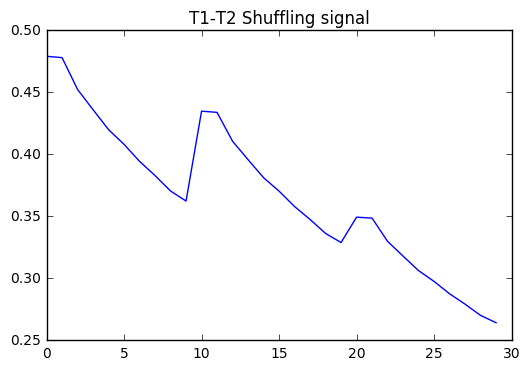

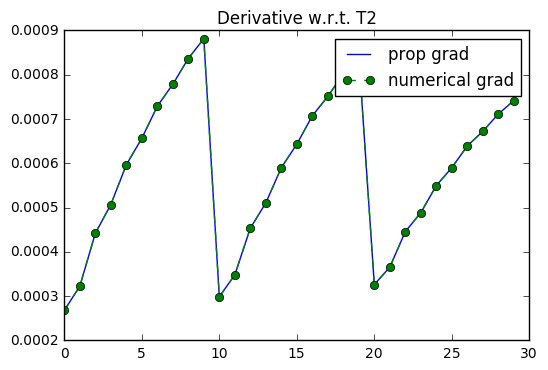

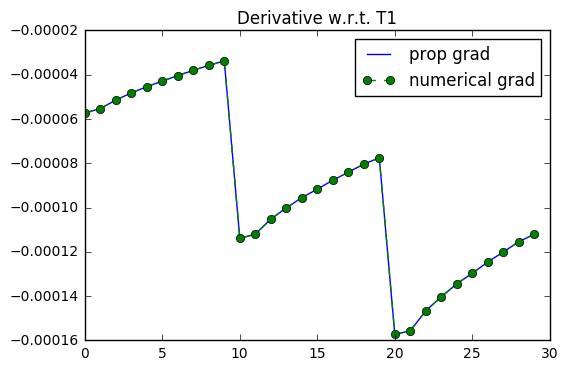

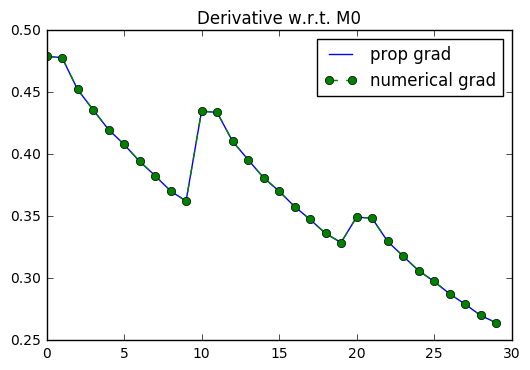

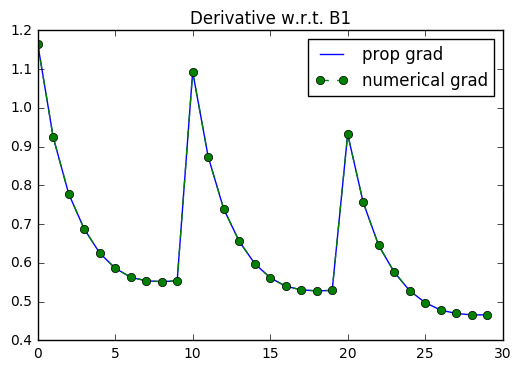

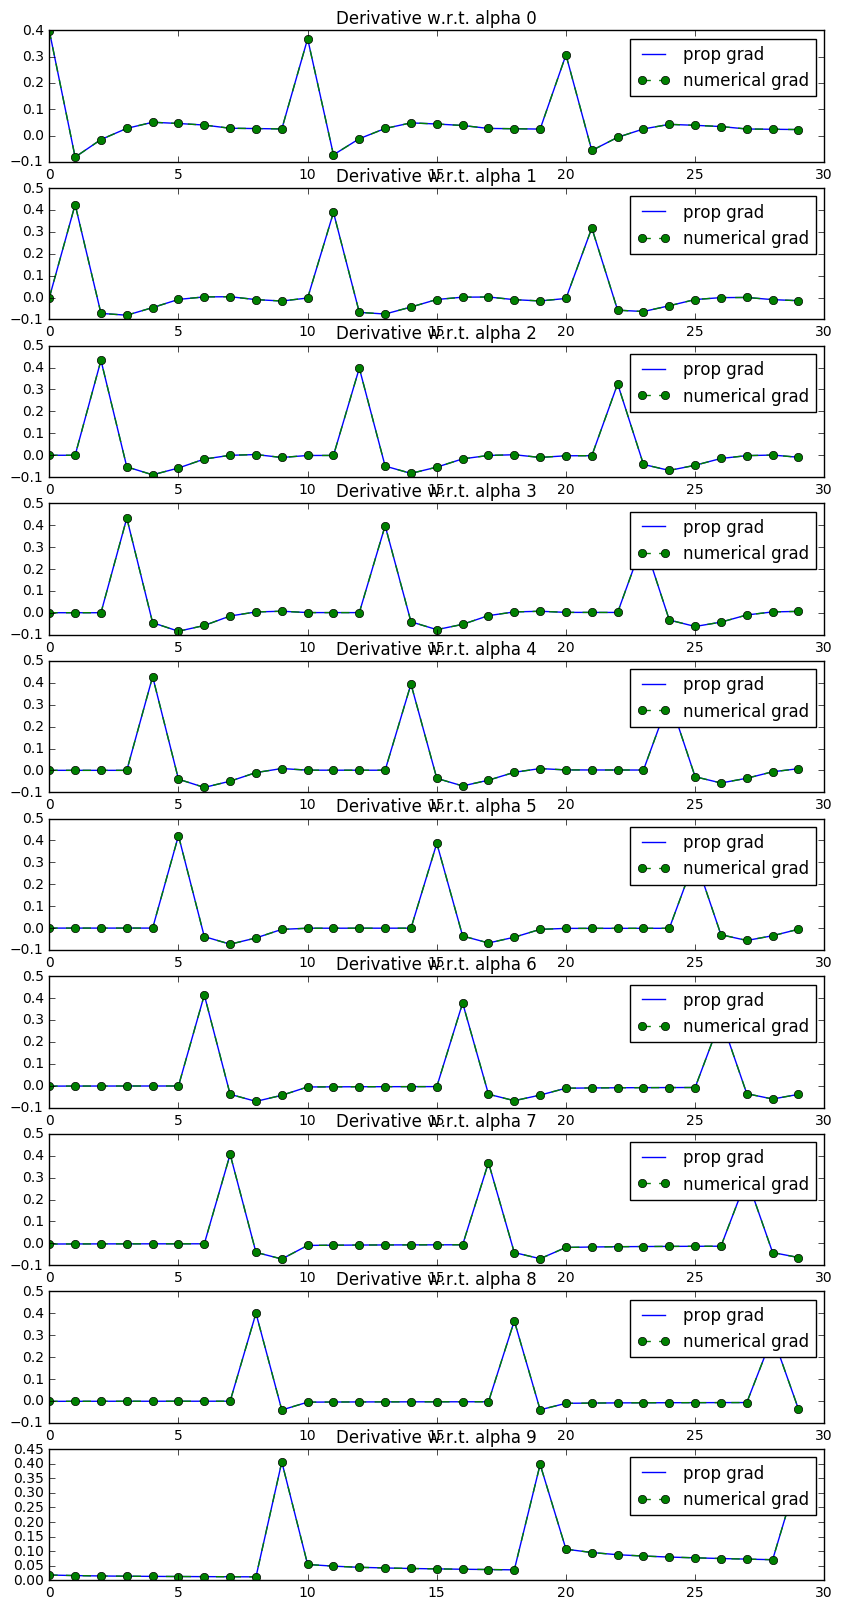

In [4]:
M0 = 1;
T1 = 1000
T2 = 100
TE = 5
B1 = .8

TRs = np.array([2800, 1700, 950])

N = len(TRs)

T = 10

echo_times = np.arange(TE, TE*(T+1), TE)

angle_ex_rad = np.pi / 2

angles_rad = 120 * np.ones((T,)) * np.pi/180
angles_rad = np.pi/180 * read_angles('flipangles.txt.814192544')[:T]

ttic = time.time()

tic = time.time()
sig = t1t2sh.t1t2shuffle_ex(angle_ex_rad, angles_rad, TE, TRs, M0, T1, T2, B1)
toc = time.time()

print 'forward model time:', toc - tic

tic = time.time()
sig_prime_T2 = t1t2sh.t1t2shuffle_ex_prime_T2(angle_ex_rad, angles_rad, TE, TRs, M0, T1, T2, B1)
toc = time.time()

print 'T2 derivative time:', toc - tic

tic = time.time()
sig_prime_T1 = t1t2sh.t1t2shuffle_ex_prime_T1(angle_ex_rad, angles_rad, TE, TRs, M0, T1, T2, B1)
toc = time.time()

print 'T1 derivative time:', toc - tic

tic = time.time()
sig_prime_M0 = t1t2sh.t1t2shuffle_ex_prime_M0(angle_ex_rad,angles_rad, TE, TRs, M0, T1, T2, B1)
toc = time.time()

print 'M0 derivative time:', toc - tic

tic = time.time()
sig_prime_B1 = t1t2sh.t1t2shuffle_ex_prime_B1(angle_ex_rad,angles_rad, TE, TRs, M0, T1, T2, B1)
toc = time.time()

print 'B1 derivative time:', toc - tic


sig_prime_alpha = np.zeros((T,T*N))
tic = time.time()
for i in range(T):
    sig_prime_alpha[i,:] = t1t2sh.t1t2shuffle_prime_alpha_idx(angles_rad, TE, TRs, M0, T1, T2, i)
toc = time.time()

print 'alpha derivative time:', toc - tic

ttoc = time.time()

print
print 'total grad time:', ttoc - ttic


def my_angles(angles, alpha, idx):
    my_angles = angles.copy()
    my_angles[idx] = alpha
    return my_angles


tic = time.time()
w1_num = np.zeros((T,N))
w2_num = np.zeros((T,N))
w0_num = np.zeros((T,N))
wb1_num = np.zeros((T,N))
wa_num = np.zeros((T,N,T))
for i in range(T):
    for j in range(N):
        w2_num[i,j] = numerical_gradient(lambda x: t1t2sh.t1t2shuffle_ex(angle_ex_rad, angles_rad, TE, np.array([TRs[j]]), M0, T1, x, B1)[i], np.array([T2]))
        w1_num[i,j] = numerical_gradient(lambda x: t1t2sh.t1t2shuffle_ex(angle_ex_rad, angles_rad, TE, np.array([TRs[j]]), M0, x, T2, B1)[i], np.array([T1]))
        w0_num[i,j] = numerical_gradient(lambda x: t1t2sh.t1t2shuffle_ex(angle_ex_rad, angles_rad, TE, np.array([TRs[j]]), x, T1, T2, B1)[i], np.array([M0]))
        wb1_num[i,j] = numerical_gradient(lambda x: t1t2sh.t1t2shuffle_ex(angle_ex_rad, angles_rad, TE, np.array([TRs[j]]), M0, T1, T2, x)[i], np.array([B1]))
        
        for k in range(T):
            wa_num[i, j, k] = numerical_gradient(lambda x: t1t2sh.t1t2shuffle(my_angles(angles_rad, x, i), TE, np.array([TRs[j]]), M0, T1, T2)[k], np.array([angles_rad[i]]))

toc = time.time()
print 'numerical grad time:', toc-tic
print

print 'T1 numerical vs prop gradient error:', np.linalg.norm(w1_num.ravel(order='F') - sig_prime_T1.T)
print 'T2 numerical vs prop gradient error:', np.linalg.norm(w2_num.ravel(order='F') - sig_prime_T2.T)
print 'M0 numerical vs prop gradient error:', np.linalg.norm(w0_num.ravel(order='F') - sig_prime_M0.T)
print 'alpha numerical vs prop gradient error:', np.linalg.norm(wa_num.ravel() - sig_prime_alpha.ravel())


plt.figure()
plt.plot(range(T*N), sig)
plt.title('T1-T2 Shuffling signal')

plt.figure()
plt.plot(range(T*N), sig_prime_T2, range(T*N), w2_num.ravel(order='F'), '--o')
plt.title('Derivative w.r.t. T2')
plt.legend(('prop grad', 'numerical grad'))

plt.figure()
plt.plot(range(T*N), sig_prime_T1, range(T*N), w1_num.ravel(order='F'), '--o')
plt.title('Derivative w.r.t. T1')
plt.legend(('prop grad', 'numerical grad'))

plt.figure()
plt.plot(range(T*N), sig_prime_M0, range(T*N), w0_num.ravel(order='F'), '--o')
plt.title('Derivative w.r.t. M0')
plt.legend(('prop grad', 'numerical grad'))

plt.figure()
plt.plot(range(T*N), sig_prime_B1, range(T*N), wb1_num.ravel(order='F'), '--o')
plt.title('Derivative w.r.t. B1')
plt.legend(('prop grad', 'numerical grad'))

plt.figure(figsize=(10,T*2))
for k in range(T):
    plt.subplot(T,1,k+1)
    plt.plot(range(T*N), sig_prime_alpha[k,:], range(T*N), wa_num[k,:,:].ravel(), '--o')

    plt.title('Derivative w.r.t. alpha %d' % k)
    plt.legend(('prop grad', 'numerical grad'))

In [5]:
M0 = 1;
T1 = 1000
T2 = 100
TE = 5

b1 = .9

TRs = np.array([2800, 1700, 950])

N = len(TRs)

T = 10

echo_times = np.arange(TE, TE*(T+1), TE)

angles_rad = 120 * np.ones((T,)) * np.pi/180
angles_rad = np.pi/180 * read_angles('flipangles.txt.814192544')[:T]


tic = time.time()
sig_prime_B1 = t1t2sh.t1t2shuffle_prime_T2(angles_rad, TE, TRs, M0, T1, T2)
toc = time.time()

print 'T2 derivative time:', toc - tic


T2 derivative time: 0.00600099563599


In [ ]:
a11 = fisher_prime_T1_T1(angles_rad, TE, TRs, M0, T1, T2)
a12 = fisher_prime_T1_T2(angles_rad, TE, TRs, M0, T1, T2)
a13 = fisher_prime_T1_M0(angles_rad, TE, TRs, M0, T1, T2)
a22 = fisher_prime_T2_T2(angles_rad, TE, TRs, M0, T1, T2)
a23 = fisher_prime_T2_M0(angles_rad, TE, TRs, M0, T1, T2)
a33 = fisher_prime_M0_M0(angles_rad, TE, TRs, M0, T1, T2)

a21 = a12
a31 = a13
a32 = a23

FIM = np.array([[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]])
print FIM

In [ ]:
FIM_det = a11*a22*a33 + a21*a32*a13 + a31*a12*a23 - a11*a32*a23 - a31*a22*a13 - a21*a12*a33
FIM_inv = 1 / FIM_det * np.array([[a22*a33-a23*a32, a13*a32-a12*a33, a12*a23-a13*a22],
                                  [a23*a31-a21*a33, a11*a33-a13*a31, a13*a21-a11*a23],
                                  [a21*a32-a22*a31, a12*a31-a11*a32, a11*a22-a12*a21]])

print FIM_inv

In [ ]:
def FIM_inv(angles_rad, TE, TRs, M0, T1, T2):
    a11 = fisher_prime_T1_T1(angles_rad, TE, TRs, M0, T1, T2)
    a12 = fisher_prime_T1_T2(angles_rad, TE, TRs, M0, T1, T2)
    a13 = fisher_prime_T1_M0(angles_rad, TE, TRs, M0, T1, T2)
    a22 = fisher_prime_T2_T2(angles_rad, TE, TRs, M0, T1, T2)
    a23 = fisher_prime_T2_M0(angles_rad, TE, TRs, M0, T1, T2)
    a33 = fisher_prime_M0_M0(angles_rad, TE, TRs, M0, T1, T2)

    a21 = a12
    a31 = a13
    a32 = a23
    FIM_det = a11*a22*a33 + a21*a32*a13 + a31*a12*a23 - a11*a32*a23 - a31*a22*a13 - a21*a12*a33
    FIM_inv = 1 / FIM_det * np.array([[a22*a33-a23*a32, a13*a32-a12*a33, a12*a23-a13*a22],
                                      [a23*a31-a21*a33, a11*a33-a13*a31, a13*a21-a11*a23],
                                      [a21*a32-a22*a31, a12*a31-a11*a32, a11*a22-a12*a21]])
    
    return FIM_inv


angles_rad = np.pi * np.ones((500,))

T1s = np.linspace(500, 1000, 50)
T2s = np.linspace(10, 1000, 50)

res1 = np.zeros((3, 3, len(T1s)))
res2 = np.zeros((3, 3, len(T2s)))

TRs = np.array([2800, 1700, 950])


for i, mT1 in enumerate(T1s):
    res1[:,:,i] = FIM_inv(angles_rad, TE, TRs, M0, mT1, T2)   

for i, mT2 in enumerate(T2s):
    res2[:,:,i] = FIM_inv(angles_rad, TE, TRs, M0, T1, mT2)

plt.plot(T2s, 10*np.log10(res2[1,1,:]))
plt.figure()
plt.plot(T1s, 10*np.log10(res1[0,0,:]))

In [ ]:
# Schur complement of I22 in I:
I11 = np.array([[a11, a12], [a12, a22]])
I12 = np.array([[a13], [a23]])
I22 = np.array([[a33]])

Schur = I11 - np.dot(I12, I12.T) / I22

print Schur

detSchur = Schur[0,0]*Schur[1,1] - Schur[0,1] * Schur[1,0]

print detSchur


In [ ]:
def detschur(angles_rad, TE, TRs, M0, T1, T2):
    a11 = fisher_prime_T1_T1(angles_rad, TE, TRs, M0, T1, T2)
    a12 = fisher_prime_T1_T2(angles_rad, TE, TRs, M0, T1, T2)
    a13 = fisher_prime_T1_M0(angles_rad, TE, TRs, M0, T1, T2)
    a22 = fisher_prime_T2_T2(angles_rad, TE, TRs, M0, T1, T2)
    a23 = fisher_prime_T2_M0(angles_rad, TE, TRs, M0, T1, T2)
    a33 = fisher_prime_M0_M0(angles_rad, TE, TRs, M0, T1, T2)
    
    I11 = np.array([[a11, a12], [a12, a22]])
    I12 = np.array([[a13], [a23]])
    I22 = np.array([[a33]])

    Schur = I11 - np.dot(I12, I12.T) / I22
    
    return Schur[0,0]*Schur[1,1] - Schur[0,1] * Schur[1,0]


In [ ]:
T1s = np.linspace(500, 3000, 100)
res = np.zeros(np.shape(T1s))
TRs = np.array([600, 1000, 2000])

def myfun(x):
    return detschur(angles_rad, TE, TRs, M0, x, T2)

tic = time.time()
res0 = joblib.Parallel(n_jobs=2, backend="threading")(joblib.delayed(myfun)(mT1) for mT1 in T1s)
toc = time.time()
print 'parallelized', toc - tic

tic = time.time()
for ii, mT1 in enumerate(T1s):
    res[ii] = detschur(angles_rad, TE, TRs, M0, mT1, T2)
toc=time.time()
print 'serial', toc - tic

plt.plot(T1s, res)

In [ ]:
T1s = np.linspace(500, 3000, 100)
T2s = np.linspace(10, 500, 100)
res = np.zeros((len(T1s), len(T2s)))
TRs = np.array([600, 1000, 2000, 5000])
for ii in range(len(T1s)):
    for jj in range(len(T2s)):
        res[ii, jj] = detschur(angles_rad, TE, TRs, M0, T1s[ii], T2s[jj])
    print ii


In [ ]:
plt.imshow(res)
plt.figure()
plt.plot(T2s, res[10,:])